In [1]:
import numpy as np
import matplotlib.pyplot as plt

#Para procesamiento de imágenes:
import cv2 #pip install opencv-python
# JuliaImages para Julia

plt.rcParams["axes.edgecolor"] = "black" # Para dar el borde de la imagen en color negro
plt.rcParams["axes.linewidth"] = 2 # Ancho del borde de la imagen

# Ayudantía 3

## Compresión de imágenes

Tenemos una imagen digital, representada por una matriz $A\in [0, 1]^{m\times n}$ (o $[0,255]^{m\times n}$), donde cada entrada representa un pixel de la imagen. Esto significa que puede ser MUY pesada de manejar/transmitir (Imagenes grandes por ejemplo). 

Queremos reducir el peso de estas, sin perder demasiada información. ¿Cómo lo hacemos? Usaremos la descomposición en valores singulares de A!

$$A = U\Sigma V^{*}$$

con $U, V$ unitarias y $\Sigma$ diagonal, que almacena los valores singulares $\sigma_1\dots,\sigma_l$ de $A$.

En clases, se vió que (si $l=\min(m, n)$):

$$A = \sigma_1u_1v_1^{*} + \dots + \sigma_l u_lv_l^{*}$$


Queremos buscar un $k<n$ tal que si elejimos $k$ valores singulares distintos:

$$A\approx \sum_{\text{choose }k\text{ from}\{1,\dots,n\}}\sigma_iu_iv_i^*$$

### Ejemplo de como ver una imagen

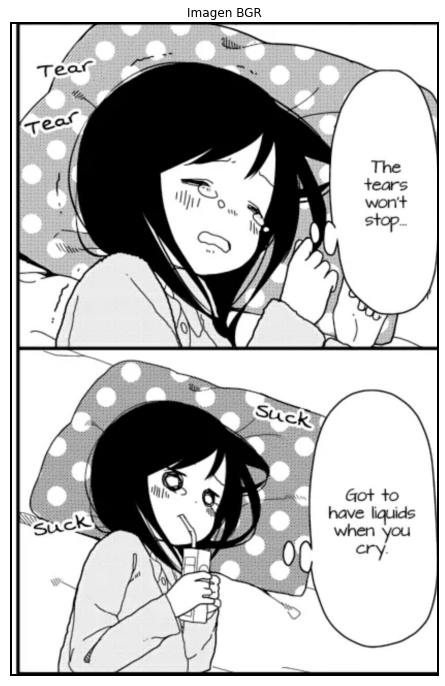

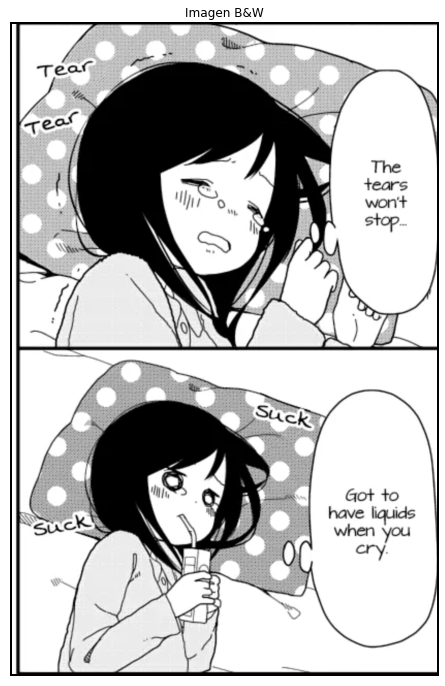

In [3]:
#Lee los canales BGR
image = cv2.imread("bocchi.png")
#image = cv2.imread("komi-san.jpeg")

#Lee en blanco y negro
gray_image = cv2.imread("bocchi.png", cv2.IMREAD_GRAYSCALE)
#gray_image = cv2.imread("komi-san.jpeg", cv2.IMREAD_GRAYSCALE)


plt.figure(figsize=(20, 12))
plt.imshow(image)
plt.xticks([]) #Para no mostrar números en ejes
plt.yticks([]) #Para no mostrar números en ejes
plt.title("Imagen BGR")
plt.show()


plt.figure(figsize=(20, 12))
plt.imshow(gray_image, cmap="gray")
plt.xticks([]) #Para no mostrar números en ejes
plt.yticks([]) #Para no mostrar números en ejes
plt.title("Imagen B&W")
#plt.axis("off")
plt.show()

Tenemos dos formatos distintos! El primero es una imagen BGR, es decir, tiene 3 canales de colores. La segunda tiene un solo canal, razón por la que hay que indicar que mapa de colores queremos usar! Veamos sus shapes!

In [4]:
print(image.shape)

print(gray_image.shape)

(2144, 1404, 3)
(2144, 1404)


Ahora, ¿Cómo sabemos cuales son los valores principales más importantes? Recordamos como los ordenamos:

$$\sigma_1\geq \sigma_2\geq\dots\geq \sigma_n\geq0$$

Entonces, los que almacenan más información corresponderían, intuitivamente, a los primeros $k$ valores singulares (más lejanos a 0).

De esta forma, falta calcular ¿Cuál es este $k$? Vemos ejemplos con la imagen anterior sobre distintos valores de $k$. Para esto, creamos una función que dado $k$ y la descomposición SVD de $A$, nos entregue la aproximación que buscamos.

In [5]:
def first_k(U, S, VT, k=1):
    """
    S = array 1D
    U, VT = array 2D
    A = U*S@VT
    """
    if k == 1:
        return S[0]*np.outer(U[:,0], VT[0,:])
    return U[:,:k]*S[:k]@VT[:k,:]

Vemos como ejemplo que serían ``U, S, VT`` y que estas si hacen la imagen original

In [6]:
U, S, VT = np.linalg.svd(gray_image, full_matrices=False)#para usar l en las matrices

#l = min(m, n)

print(U.shape)  # U  mxl
print(S.shape)  # S  lx1 (representa una diagonal)
print(VT.shape) # VT lxn

(2144, 1404)
(1404,)
(1404, 1404)


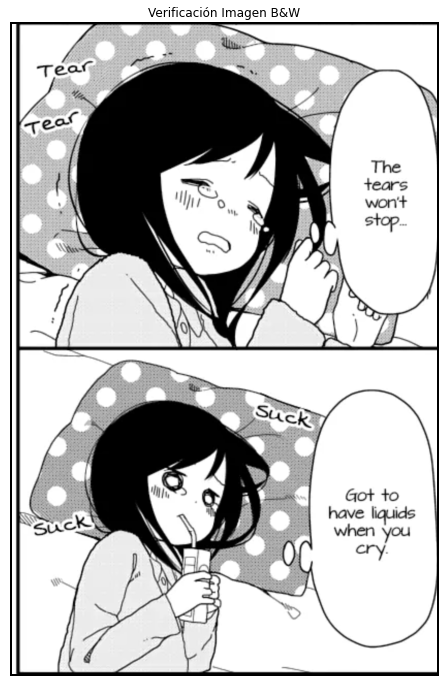

In [7]:
plt.figure(figsize=(20, 12))
plt.imshow(U*S@VT, cmap="gray")
plt.xticks([]) #Para no mostrar números en ejes
plt.yticks([]) #Para no mostrar números en ejes
plt.title("Verificación Imagen B&W")
#plt.axis("off")
plt.show()

Ahora, recuperemos algunos valores de $k$ para ver como es la aproximación de la imagen. Digamos, $k=1, 25, 50, 100, 200, 400$.

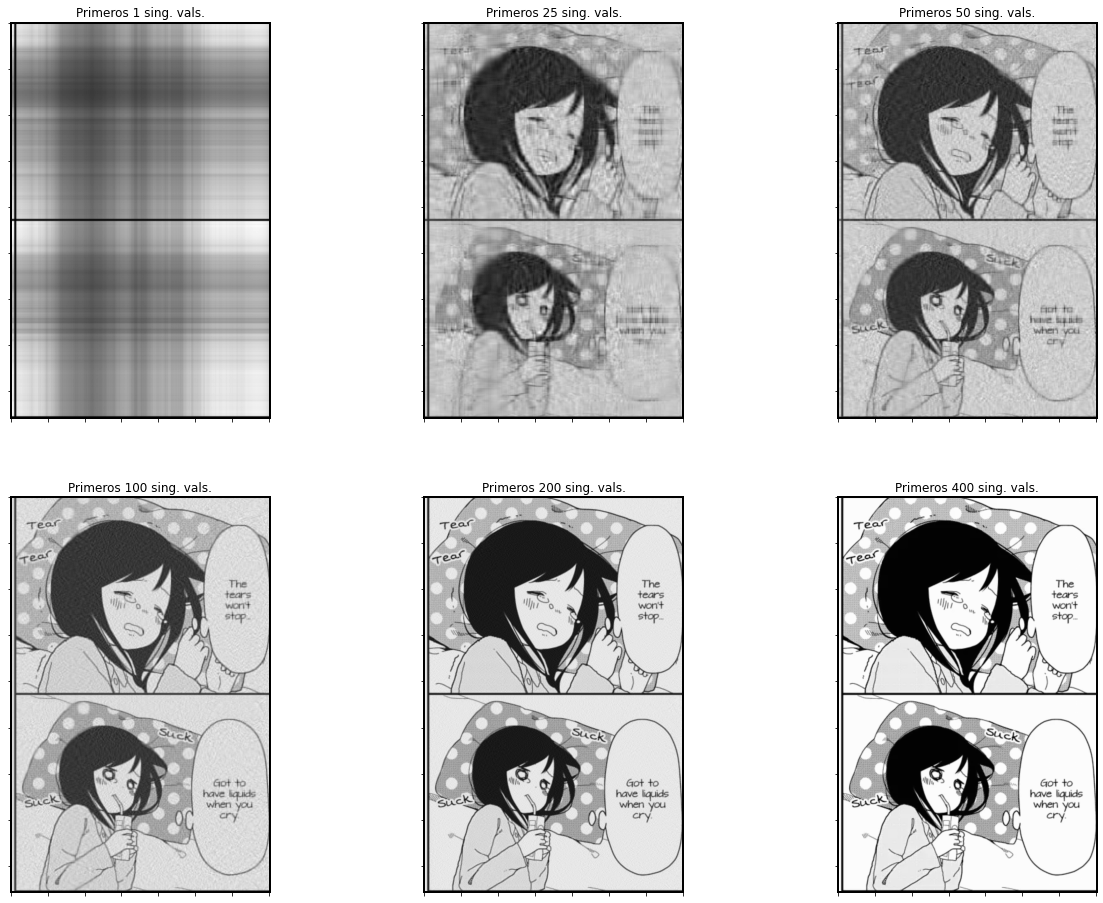

In [8]:
fig, ax = plt.subplots(2, 3, figsize=(21, 16))

for index, k in enumerate([1, 25, 50, 100, 200, 400]):

    ax[index//3, index%3].imshow(first_k(U, S, VT, k=k), cmap="gray")
    ax[index//3, index%3].set_xticklabels([]) #Para no mostrar números en ejes
    ax[index//3, index%3].set_yticklabels([]) #Para no mostrar números en ejes
    ax[index//3, index%3].set_title(f"Primeros {k} sing. vals.")

plt.show()

Ahora, tenemos que responder la pregunta central. ¿Cuál $k$ es el mejor en términos de almacenamiento? Al final del día, comprimimos para reducir el almacenamiento, entonces debemos tener en cuenta esto. Vemos el análisis de cuantos datos debemos almacenar:

- Almacenar $A$ entera cuesta $mn$ casillas
- Almacenar $u_i$ cuesta $m$ casillas
- Almacenar $\sigma_i$ cuesta $1$ casilla
- Almacenar $v_i^*$ cuesta $n$ casillas. 

Entonces:

- Almacenar $u_i\sigma_i v_i^*$ cuesta $m+n+1$ casillas.

De esta forma, si tenemos $k$ de estos términos, entonces necesitamos que:

$$k(m+n+1)\leq mn$$

Para que el almacenamiento no supere al de la imagen original.


Así, si elejimos un $k'<k$, estaríamos ahorrando espacio en el almacenado de la imagen. Veamos como funciona en la imagen que tratamos:

In [9]:
def find_k_same_store(A):
    m, n = A.shape
    return int(np.ceil(m*n/(m+n+1)))

print(find_k_same_store(gray_image))

849


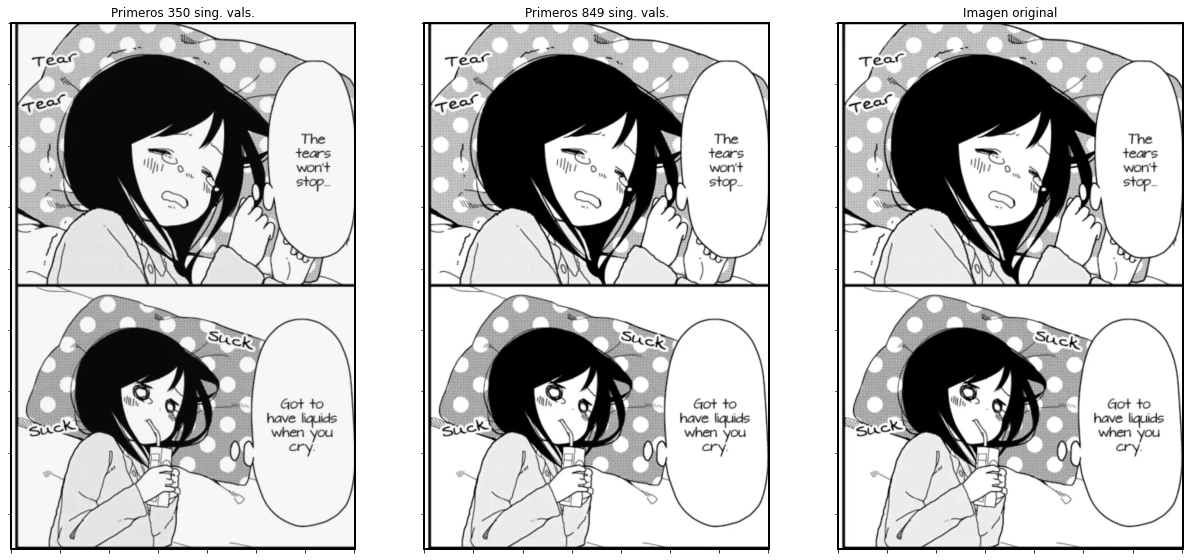

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(21, 20))

for index, k in enumerate([350, find_k_same_store(gray_image)]):

    ax[index].imshow(first_k(U, S, VT, k=k), cmap="gray")
    ax[index].set_xticklabels([]) #Para no mostrar números en ejes
    ax[index].set_yticklabels([]) #Para no mostrar números en ejes
    ax[index].set_title(f"Primeros {k} sing. vals.")

ax[2].imshow(gray_image, cmap="gray")
ax[2].set_xticklabels([]) #Para no mostrar números en ejes
ax[2].set_yticklabels([]) #Para no mostrar números en ejes
ax[2].set_title(f"Imagen original")

plt.show()

Veamos cual es el error relativo que surge de aproximar $A$ por esta compresión con $k$ término $A_k$. Para esto:

$$\frac{\|A_k-A\|_2}{\|A\|_2} = \frac{\|A_{k}-A\|_2}{\sigma_1}$$

Luego, si $l=\min(m, n)$, entonces:

$$A-A_k = \sum_{i=1}^{l}u_i\sigma_iv_i^* - \sum_{i=1}^{k}u_i\sigma_iv_i^{*} = \sum_{i=k+1}^{l}u_i\sigma_iv_i^{*}$$

Con esto se sigue:

$$\begin{align*}\|A_k-A\|_2^2 &\leq \|A_k-A\|_F^2\\
&=\sum_{i=k+1}^{l}\sigma_{i}^{2}\\
&\leq (l-k-1)\sigma_{k+1}^2
\end{align*}$$

Entonces:

$$\frac{\|A-A_k\|_2}{\|A\|_2}\leq \sqrt{(l-k-1)}\frac{\sigma_{k+1}}{\sigma_{1}}$$

Veamos la gráfica de este:

In [12]:
l = min(gray_image.shape)

#Eje X: Que pasa cuando tomo más y más valores singulares
k_list = np.arange(1, l, 20)

#La cota obtenida
cota_list = [np.sqrt(l-k-1)*S[k]/S[0] for k in k_list]

#Error relativo
def Err_relativo(A, U, S, VT, k):
    Ak = first_k(U, S, VT, k=k)
    num = np.linalg.norm(A-Ak, ord=2)
    den = np.linalg.norm(A, ord=2)
    return num/den

err_R = [Err_relativo(gray_image, U, S, VT, k) for k in k_list]

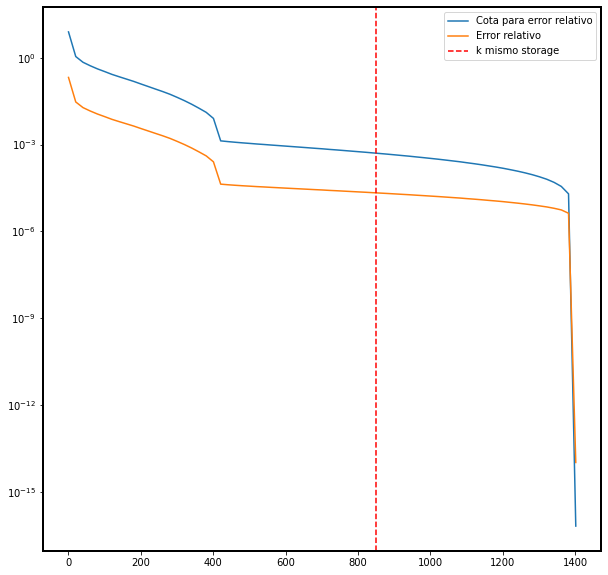

In [13]:
plt.figure(figsize=(10, 10))
plt.plot(k_list, cota_list, label="Cota para error relativo")
plt.plot(k_list, err_R, label="Error relativo")
#plt.plot(k_list, err_A, label="Error absoluto")
plt.axvline(find_k_same_store(gray_image), 0, 10, ls="--", color="red", label="k mismo storage")
plt.yscale("log")
#plt.xscale("log")
plt.legend(loc="best")
plt.show()

In [14]:
np.linalg.norm(gray_image-first_k(U, S, VT, 500), 2)

12.157352199757867

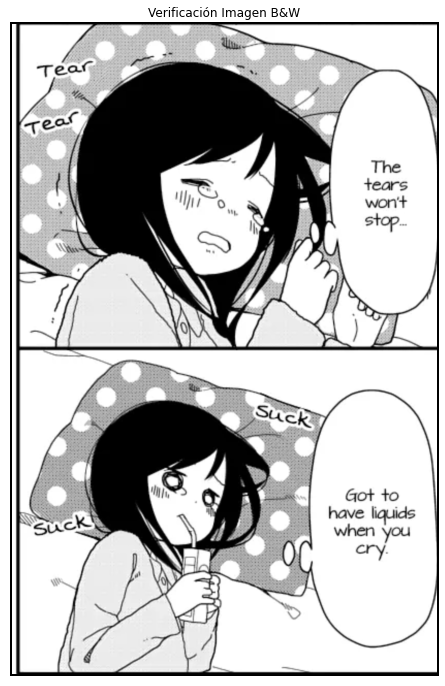

In [15]:
plt.figure(figsize=(20, 12))
plt.imshow(first_k(U, S, VT, 500), cmap="gray")
plt.xticks([]) #Para no mostrar números en ejes
plt.yticks([]) #Para no mostrar números en ejes
plt.title("Verificación Imagen B&W")
#plt.axis("off")
plt.show()

## Deblurring de imágenes

Tenemos una imagen borrosa la cual queremos hacer visible (más nítida, más bordes, etc). Mostramos otra imagen ejemplo en blanco y negro

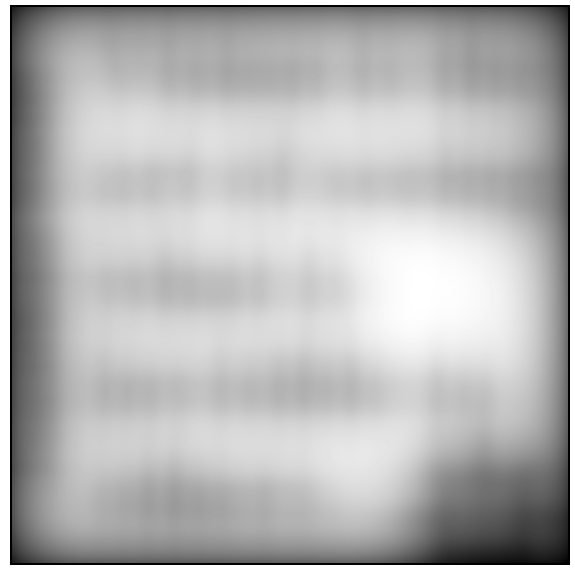

In [16]:
import scipy.io #Para leer archivo .mat con los filtros para deblurring y la imagen test

data = scipy.io.loadmat('proj1data.mat')
A = data["A"]
B = data["B"]
G = data["G"]

M, N = G.shape

### Como blurrear una imagen con la librería
#img2 = cv2.imread("bocchi_logo.png", cv2.IMREAD_GRAYSCALE)

#blurred_img = cv2.blur(img2, (51, 51)) # Box blur
#blurred_img = cv2.GaussianBlur(img2, (101, 101), 0)
#G = blurred_img
#################

plt.figure(figsize=(10,18))
plt.imshow(G, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.show()

Pensamos en este problema como volver a obtener una imagen $f$ a partir de una imagen $g$ con ruido la cual fue sujeta a una transformación $K$. Es decir, resolver para $f$ el sistema:

$$Kf = g$$

Para esto, podemos usar SVD para resolver el problema como sigue. Si $K=U\Sigma V^*$, entonces $K^{-1}=V\Sigma^{-1} U^{*}$. De esta forma:

$$f = K^{-1}g =\sum_{i=1}^{n}\frac{u_i^*g}{\sigma_i}v_i$$

Y al igual que antes, podemos tomar los primeros $p$ términos más significativos para reducir el costo de almacenamiento.

Ahora, ¿cómo construimos $K$? Podemos crear un filtro separable en dos matrices $A, B$ tal que:

$$K = A\otimes B$$

En qué nos beneficia esto? Por que $K$ sigue siendo de $mn\times mn$. La gracia ahora es que como $K$ es resultado del producto kronecker de dos matrices, se cumple que:

$$K = U\Sigma V^* = (U_A\otimes U_B)(\Sigma_A\otimes \Sigma_B)(V_A\otimes V_B)^{*}$$

Entonces, es fácil encontrar la descomposición SVD de $K$.

Primero, vemos que:

$$A = U_A\Sigma_A V_A^*$$

$$B = U_B\Sigma_B V_B^*$$

En este caso, tomamos $U_A, U_B$ matrices cuadradas de $m\times m$, mientras que $\Sigma_A, \Sigma_B$ son de $m\times n$. Como la imagen que usamos es cuadrada todas las matrices son iguales.

In [17]:
UA, SA, VAT = np.linalg.svd(A)
UB, SB, VBT = np.linalg.svd(B)

VA, VB = VAT.conj().T, VBT.conj().T

Luego, revisamos cual es el procedimiento. Como

$$Kf = g \Leftrightarrow K\text{vec}(F) = \text{vec}(G)$$

Donde $F, G$ son matrices y $f, g$ son vectores, entonces vemos que:

$$\begin{align*}
K\text{vec}(F) &= g\\
(A\otimes B)\text{vec}(F)&=\\
\text{vec}(BFA^*)&=\text{vec}(G)
\end{align*}$$

Luego:

$$
\begin{align*}
U_B\Sigma_{B}V_B^*FV_A\Sigma_{A}U_A^* &= G\\
\Sigma_{B}V_B^*FV_A\Sigma_{A} &= U_{B}^*GU_{A}\\
&=\hat{G}
\end{align*}$$

Como dijimos antes:

$$f = K^{-1}g =\sum_{i=1}^{n}\frac{u_i^*g}{\sigma_i}v_i$$

Entonces, hay que calcular los valores singulares de $\Sigma_{A}\otimes\Sigma_B$, pero estos son simplemente $\sigma_{A, i}\sigma_{B,j}$. De esta forma, con el producto kronecker entre ambas diagonales $\Sigma_A, \Sigma_{B}$ es posible obtener los valores singulares de $\Sigma$, y por lo tanto, dividir punto a punto a $\hat{G}$. Para esto es necesario ordenar $\Sigma$!! Luego, obtendríamos lo siguiente

$$V_B^*FV_A = \hat{F} = \text{division punto a punto de }\hat{G}\text{ con }\Sigma$$

Finalmente, podemos despejar F como uno esperaría, y así obtenemos una caracterización llena de $F$.

Ahora surge otro problema: No podemos hacer esto simplemente y ocupar todas las entradas. Por que?

1) Desconocemos $K$

2) Desconocemos que tipo de ruido tiene $G$

Entonces, en el proceso de reconstrucción de la imagen no podemos tomar $p$ muy grandes (cercanos al número de valores singulares en total de $\Sigma$) o $p$ muy pequeños (por que no habría información suficiente)

In [39]:
Ghat = UB.conj().T@G@UA # Ghat como indicado anteriormente
S = np.outer(SB, SA.conj())

s = np.reshape(S, (M*N,))
perm, SortedS = np.argsort(s)[::-1], np.sort(s)[::-1]

#Para usar como índices I guess?
iprm = np.zeros(M*N, dtype=int)
iprm[perm] = np.arange(M*N)

p = 100

ssnew = np.append(s[:p], np.zeros(M*N-p))
Snew = ssnew[iprm].reshape((M, N))

Fhat = Ghat/S # Element-wise division

In [40]:
Snew_reloaded = np.zeros_like(Snew)
for i in range(M):
    for j in range(N):
        if Snew[i,j] > 0:
            Snew_reloaded[i,j] = 1

Fnew = Fhat*Snew_reloaded # Element-wise multiplication 

F = VB@Fnew@VAT

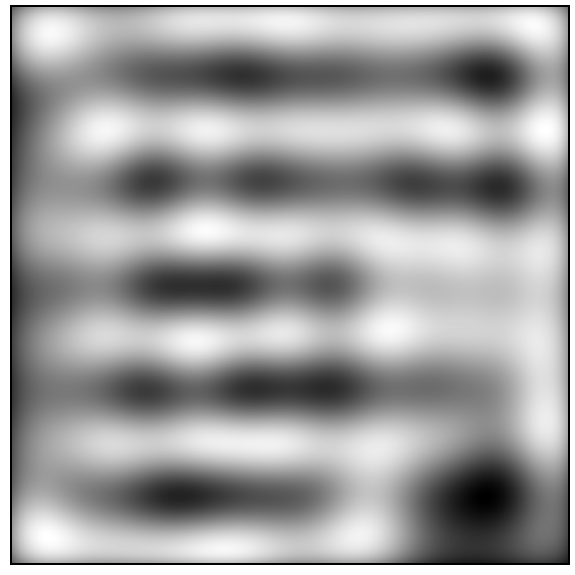

In [41]:
plt.figure(figsize=(10,18))
plt.imshow(F, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.show()